# 1) Thiết lập môi trường & GPU (Import • Version • CUDA • Device)

In [17]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F
import colorama
import random
import plotly.express as px
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices('GPU')[0], True
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Torch version: 2.9.0+cu128
Torchvision version: 0.24.0+cu128
CUDA available: True
CUDA version: 12.8
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))
print("GPU name (TF):", tf.test.gpu_device_name())

import torch
print("\nPyTorch version:", torch.__version__)
print("CUDA available (PyTorch):", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name (PyTorch):", torch.cuda.get_device_name(0))

TensorFlow version: 2.10.0
CUDA available: False
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU name (TF): /device:GPU:0

PyTorch version: 2.9.0+cu128
CUDA available (PyTorch): True
GPU name (PyTorch): NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
def chon_thiet_bi_mac_dinh():
    if torch.cuda.is_available():
        print("✅ Đã phát hiện GPU:", torch.cuda.get_device_name(0))
        return torch.device("cuda")
    else:
        print("⚠️ Không có GPU, sử dụng CPU để huấn luyện.")
        return torch.device("cpu")


def dua_len_thiet_bi(du_lieu, thiet_bi):
    if isinstance(du_lieu, (list, tuple)):
        return [dua_len_thiet_bi(x, thiet_bi) for x in du_lieu]
    return du_lieu.to(thiet_bi, non_blocking=True)


class TaiDuLieuTheoThietBi:
    def __init__(self, dataloader, thiet_bi):
        self.dataloader = dataloader
        self.thiet_bi = thiet_bi

    def __iter__(self):
        for batch in self.dataloader:
            yield dua_len_thiet_bi(batch, self.thiet_bi)

    def __len__(self):
        return len(self.dataloader)

device = chon_thiet_bi_mac_dinh()
device


✅ Đã phát hiện GPU: NVIDIA GeForce RTX 3050 Laptop GPU


device(type='cuda')

In [5]:
# Reset TensorFlow session
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear session
K.clear_session()

# Kiểm tra GPU (không cấu hình gì thêm)
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Phát hiện {len(gpus)} GPU")
else:
    print("⚠️ Không phát hiện GPU - sẽ dùng CPU")

TensorFlow version: 2.10.0
✅ Phát hiện 2 GPU


In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear session để tránh conflict
K.clear_session()

# Cấu hình GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Cho phép GPU tăng trưởng bộ nhớ động
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Chỉ dùng GPU đầu tiên (tránh conflict)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        print(f"✅ Đã cấu hình GPU: {gpus[0]}")
        print("✅ Memory growth: Enabled")
        
    except RuntimeError as e:
        print(f"⚠️ Lỗi cấu hình GPU: {e}")
else:
    print("⚠️ Không phát hiện GPU")

✅ Đã cấu hình GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ Memory growth: Enabled


# 2) Chuẩn bị dữ liệu (Cấu trúc thư mục • Split train/val/test • Kiểm tra số lượng)

In [ ]:

class_names = ['Cat', 'Dog']

cat_dir = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\Cat"
dog_dir = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\Dog"

# Đếm số lượng ảnh
n_cats = len(os.listdir(cat_dir))
n_dogs = len(os.listdir(dog_dir))
n_images = [n_cats, n_dogs]

# Vẽ biểu đồ tròn
px.pie(names=class_names, values=n_images, title="Tỷ lệ ảnh mèo và chó")
px.pie(names=class_names, values=n_images)


In [ ]:
import os

# ⚙️ Đường dẫn gốc trên máy của bạn
base_dir = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages"

# 🧩 Các thư mục con cần tạo
folders = [
    os.path.join(base_dir, "training", "cats"),
    os.path.join(base_dir, "training", "dogs"),
    os.path.join(base_dir, "validation", "cats"),
    os.path.join(base_dir, "validation", "dogs"),
    os.path.join(base_dir, "test", "cats"),
    os.path.join(base_dir, "test", "dogs")
]

# 🔹 Tạo toàn bộ thư mục (nếu chưa có)
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("✅ Đã tạo xong tất cả thư mục training, validation và test!")


✅ Đã tạo xong tất cả thư mục training, validation và test!


In [ ]:
import os

# 🐾 Đường dẫn gốc chứa dữ liệu gốc (Cat & Dog)
CAT_DIR = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\Cat"
DOG_DIR = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\Dog"

# ⚙️ Đường dẫn tới nơi lưu dữ liệu sau khi chia train / validation / test
TRAINING_DIR = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\training"
VALIDATION_DIR = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\validation"
TEST_DIR = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages\test"

# 📂 Đường dẫn cụ thể cho từng loại ảnh
TRAINING_CATS = os.path.join(TRAINING_DIR, "cats")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats")
TEST_CATS = os.path.join(TEST_DIR, "cats")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs")
TEST_DOGS = os.path.join(TEST_DIR, "dogs")

# ✅ Bật chia dữ liệu test
INCLUDE_TEST = True


In [10]:
print(len(os.listdir(TRAINING_CATS)))
print(len(os.listdir(TRAINING_DOGS)))

print(len(os.listdir(VALIDATION_CATS)))
print(len(os.listdir(VALIDATION_DOGS)))

print(len(os.listdir(TEST_CATS)))
print(len(os.listdir(TEST_DOGS)))
print("✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!")


11250
11250
625
625
625
625
✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!


In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        file_path = os.path.join(main_dir, file)
        if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
            files.append(file)

    if len(files) == 0:
        print(f"⚠️ Không tìm thấy ảnh trong thư mục: {main_dir}")
        return

    random.shuffle(files)

    train_size = int(len(files) * split_size)
    if include_test_split:
        valid_size = int((len(files) - train_size) / 2)
    else:
        valid_size = len(files) - train_size

    train_files = files[:train_size]
    valid_files = files[train_size:train_size + valid_size]
    test_files = files[train_size + valid_size:] if include_test_split else []

    for file in train_files:
        copyfile(os.path.join(main_dir, file), os.path.join(training_dir, file))
    for file in valid_files:
        copyfile(os.path.join(main_dir, file), os.path.join(validation_dir, file))
    for file in test_files:
        copyfile(os.path.join(main_dir, file), os.path.join(test_dir, file))

    print(f"✅ Chia dữ liệu xong cho {os.path.basename(main_dir)}:")
    print(f"   - Train: {len(train_files)} ảnh")
    print(f"   - Validation: {len(valid_files)} ảnh")
    if include_test_split:
        print(f"   - Test: {len(test_files)} ảnh")



# ==== SPLIT ====
split_data(
    main_dir=CAT_DIR,
    training_dir=TRAINING_CATS,
    validation_dir=VALIDATION_CATS,
    test_dir=TEST_CATS,
    include_test_split=True,
    split_size=0.9
)

split_data(
    main_dir=DOG_DIR,
    training_dir=TRAINING_DOGS,
    validation_dir=VALIDATION_DOGS,
    test_dir=TEST_DOGS,
    include_test_split=True,
    split_size=0.9
)

In [11]:
print(len(os.listdir(TRAINING_CATS)))
print(len(os.listdir(TRAINING_DOGS)))

print(len(os.listdir(VALIDATION_CATS)))
print(len(os.listdir(VALIDATION_DOGS)))

print(len(os.listdir(TEST_CATS)))
print(len(os.listdir(TEST_DOGS)))
print("✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!")


11250
11250
625
625
625
625
✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!


# 3) Data pipeline (ImageDataGenerator • Train/Val/Test loaders)

In [ ]:
image_size = 128          
image_channel = 3         
bat_size = 32             

train_datagen = ImageDataGenerator(
    rescale=1./255,      
    rotation_range = 15, 
    horizontal_flip = True, 
    zoom_range = 0.2,       
    shear_range = 0.1,     
    fill_mode = 'reflect',  
    width_shift_range = 0.1, 
    height_shift_range = 0.1 
)

test_datagen = ImageDataGenerator(rescale=1./255)

BASE = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\source_2\PetImages"

train_gen = train_datagen.flow_from_directory(
    directory = BASE + r"\training",
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size
)

val_gen = test_datagen.flow_from_directory(
    directory = BASE + r"\validation",
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size,
    shuffle=False        
)

test_gen = test_datagen.flow_from_directory(
    directory = BASE + r"\test",
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size,
    shuffle=False       
)


Found 22500 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


# 4) Mô hình CNN & Huấn luyện (Kiến trúc • Callbacks • Compile • Fit • Save)

In [13]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', input_shape=(image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 1 ===============
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 2 ===============
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 3 ===============
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== FULLY CONNECTED ===============
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [14]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,            
    factor = 0.5,            
    min_lr = 1e-5,           
    verbose = 1
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=3,             
    restore_best_weights=True, 
    verbose=1
)

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:

cat_dog = model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=[early_stoping, learning_rate_reduction],
    epochs=30
)

Epoch 1/30
704/704 [==============================] - 84s 118ms/step - loss: 0.3168 - accuracy: 0.8598 - val_loss: 0.3813 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 2/30
704/704 [==============================] - 81s 115ms/step - loss: 0.3011 - accuracy: 0.8699 - val_loss: 0.5517 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 3/30
704/704 [==============================] - 82s 116ms/step - loss: 0.2818 - accuracy: 0.8794 - val_loss: 0.2059 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 4/30
704/704 [==============================] - 81s 116ms/step - loss: 0.2648 - accuracy: 0.8862 - val_loss: 0.2321 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/30
704/704 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.8838
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
704/704 [==============================] - 79s 112ms/step - loss: 0.2731 - accuracy: 0.8838 - val_loss: 0.2500 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 6/30
704/704 [=============================

In [28]:
# Save the Model
model.save("model_cat_vs_dog_classification_final.h5")

# 5) Đánh giá & trực quan (Accuracy/Loss • Train/Val/Test metrics • Predict)

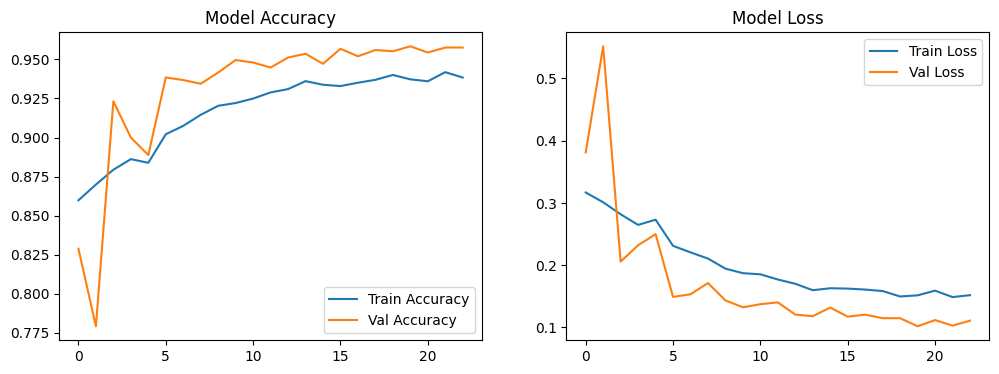

In [20]:
# Sau khi training xong
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cat_dog.history['accuracy'], label='Train Accuracy')
plt.plot(cat_dog.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(cat_dog.history['loss'], label='Train Loss')
plt.plot(cat_dog.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [21]:
# Cell 2 — Bảng so sánh Train vs Validation (dùng .history)
import numpy as np
import pandas as pd

hist = cat_dog.history
train_acc = hist['accuracy']
val_acc   = hist['val_accuracy']
train_loss = hist['loss']
val_loss   = hist['val_loss']

final_epoch = len(train_acc) - 1
best_val_acc_epoch  = int(np.argmax(val_acc))
best_val_loss_epoch = int(np.argmin(val_loss))

compare_df = pd.DataFrame({
    'Type': ['Final', 'Best Val Acc', 'Best Val Loss'],
    'Epoch': [final_epoch, best_val_acc_epoch, best_val_loss_epoch],
    'Train Accuracy': [train_acc[final_epoch], train_acc[best_val_acc_epoch], train_acc[best_val_loss_epoch]],
    'Val Accuracy':   [val_acc[final_epoch],   val_acc[best_val_acc_epoch],   val_acc[best_val_loss_epoch]],
    'Train Loss':     [train_loss[final_epoch], train_loss[best_val_acc_epoch], train_loss[best_val_loss_epoch]],
    'Val Loss':       [val_loss[final_epoch],   val_loss[best_val_acc_epoch],   val_loss[best_val_loss_epoch]],
})
pd.set_option('display.float_format','{:.4f}'.format)
display(compare_df)

,Type,Epoch,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,Final,22,0.9384,0.9576,0.1519,0.1110
1,Best Val Acc,19,0.9372,0.9584,0.1516,0.1019
2,Best Val Loss,19,0.9372,0.9584,0.1516,0.1019


<Figure size 480x480 with 0 Axes>

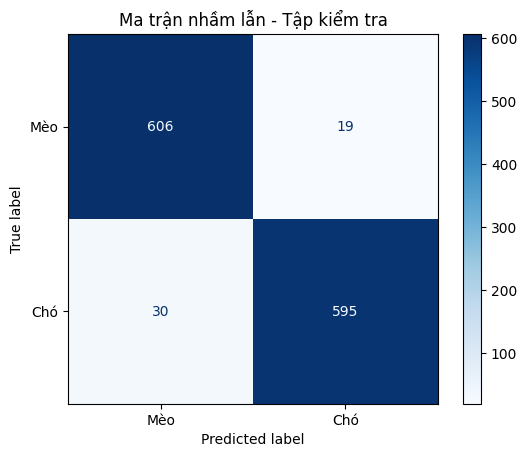


📊 Báo cáo phân loại (Tập kiểm tra):
              precision    recall  f1-score   support

         Mèo     0.9528    0.9696    0.9611       625
         Chó     0.9691    0.9520    0.9605       625

    accuracy                         0.9608      1250
   macro avg     0.9609    0.9608    0.9608      1250
weighted avg     0.9609    0.9608    0.9608      1250



In [25]:
# Cell 3 — Ma trận nhầm lẫn + Báo cáo phân loại (Test)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Dự đoán trên tập test
result = model.predict(test_gen, verbose=0)
y_pred = (result > 0.5).astype(int).ravel()
y_true = test_gen.labels

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Mèo', 'Chó'])

plt.figure(figsize=(4.8, 4.8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Ma trận nhầm lẫn - Tập kiểm tra')
plt.show()

print("\n📊 Báo cáo phân loại (Tập kiểm tra):")
print(classification_report(y_true, y_pred, target_names=['Mèo', 'Chó'], digits=4))

In [23]:
# ==================== ĐÁNH GIÁ MÔ HÌNH ====================

# Đánh giá trên tập train
loss_train, acc_train = model.evaluate(train_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập TRAIN: {acc_train*100:.2f}%")
print(f"Giá trị Loss trên tập TRAIN: {loss_train:.4f}")

# Đánh giá trên tập validation
loss_val, acc_val = model.evaluate(val_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập VALIDATION: {acc_val*100:.2f}%")
print(f"Giá trị Loss trên tập VALIDATION: {loss_val:.4f}")

# Đánh giá trên tập test
loss_test, acc_test = model.evaluate(test_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập TEST: {acc_test*100:.2f}%")
print(f"Giá trị Loss trên tập TEST: {loss_test:.4f}")


d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning:

Truncated File Read



Độ chính xác (Accuracy) trên tập TRAIN: 95.83%
Giá trị Loss trên tập TRAIN: 0.1048
Độ chính xác (Accuracy) trên tập VALIDATION: 95.84%
Giá trị Loss trên tập VALIDATION: 0.1019
Độ chính xác (Accuracy) trên tập TEST: 96.08%
Giá trị Loss trên tập TEST: 0.1156


# 6) Demo suy luận (Gradio multiple images)

In [26]:
%gui tk


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import os

MODEL_PATH = r"D:\DH_GTVT\NNLT_PY\BTCK_N8\model_cat_vs_dog_classification_final.h5"
model = load_model(MODEL_PATH)
IMG_SIZE = 128

def predict_multi(files):
    outs = []
    for f in files:
        img = Image.open(f).convert("RGB")
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        arr = np.expand_dims(np.array(img_resized)/255.0, axis=0)

        p = model.predict(arr)[0][0]
        if p > 0.5:
            label = "Dog"
            conf = p * 100
        else:
            label = "Cat"
            conf = (1-p) * 100

        outs.append( (img, f"{label} {conf:.2f}%") )
    return outs

demo = gr.Interface(
    fn=predict_multi,
    inputs=gr.File(label="Chọn nhiều ảnh", file_count="multiple", type="filepath"),
    outputs=gr.Gallery(label="Kết quả", show_label=True),
    title="Cat vs Dog Classification (multiple images)"
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 24ms/step
